# MovieLens 1M: Sistemi preporuka zasnovani na uzajamnom filtriranju koristeći matricu kovarijansi

In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection
import matplotlib.pyplot as plt

Učitaćemo podatke iz datoteke <i><b>ratings.dat</b></i> sa kolonama 'user', 'item', 'rating' i 'timestamp':

In [2]:
header = ['user', 'item', 'rating', 'timestemp']

In [3]:
data = pd.read_table('data/ratings.dat', sep = '::', names = header, engine = 'python')

In [4]:
data.head()

,user,item,rating,timestemp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user       1000209 non-null  int64
 1   item       1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestemp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


### Vizualizacija podataka
Radi vizualizacije podataka učitaćemo podatke iz datoteke <i><b>movies.dat</b></i>, a zatim ćemo ih spojiti sa već učitanim podacima:

In [6]:
columns = ["item", "title", "genre"]

In [7]:
movies = pd.read_csv('data/movies.dat', sep='::', names = columns, engine = 'python')

In [8]:
movies.head()

,item,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
data_movies = pd.merge(data, movies, on='item')

In [10]:
data_movies.head()

,user,item,rating,timestemp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama


Prikaz prvih 10 filmova sa najvećom srednjom ocenom:

In [11]:
data_movies.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
Gate of Heavenly Peace, The (1995)           5.0
Lured (1947)                                 5.0
Ulysses (Ulisse) (1954)                      5.0
Smashing Time (1967)                         5.0
Follow the Bitch (1998)                      5.0
Song of Freedom (1936)                       5.0
Bittersweet Motel (2000)                     5.0
Baby, The (1973)                             5.0
One Little Indian (1973)                     5.0
Schlafes Bruder (Brother of Sleep) (1995)    5.0
Name: rating, dtype: float64

Prikaz prvih 10 filmova koji su najviše bili ocenjeni:

In [12]:
data_movies.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

title
American Beauty (1999)                                   3428
Star Wars: Episode IV - A New Hope (1977)                2991
Star Wars: Episode V - The Empire Strikes Back (1980)    2990
Star Wars: Episode VI - Return of the Jedi (1983)        2883
Jurassic Park (1993)                                     2672
Saving Private Ryan (1998)                               2653
Terminator 2: Judgment Day (1991)                        2649
Matrix, The (1999)                                       2590
Back to the Future (1985)                                2583
Silence of the Lambs, The (1991)                         2578
Name: rating, dtype: int64

In [13]:
ratings = pd.DataFrame(data_movies.groupby('title')['rating'].mean())
ratings['count'] = pd.DataFrame(data_movies.groupby('title')['rating'].count())
ratings = pd.merge(ratings, movies, on='title')
ratings.sort_values(by='count', ascending=False).head(10)

,title,rating,count,item,genre
127,American Beauty (1999),4.317386,3428,2858,Comedy|Drama
3153,Star Wars: Episode IV - A New Hope (1977),4.453694,2991,260,Action|Adventure|Fantasy|Sci-Fi
3154,Star Wars: Episode V - The Empire Strikes Back...,4.292977,2990,1196,Action|Adventure|Drama|Sci-Fi|War
3155,Star Wars: Episode VI - Return of the Jedi (1983),4.022893,2883,1210,Action|Adventure|Romance|Sci-Fi|War
1789,Jurassic Park (1993),3.763847,2672,480,Action|Adventure|Sci-Fi
2894,Saving Private Ryan (1998),4.337354,2653,2028,Action|Drama|War
3293,Terminator 2: Judgment Day (1991),4.058513,2649,589,Action|Sci-Fi|Thriller
2112,"Matrix, The (1999)",4.315830,2590,2571,Action|Sci-Fi|Thriller
258,Back to the Future (1985),3.990321,2583,1270,Comedy|Sci-Fi
2990,"Silence of the Lambs, The (1991)",4.351823,2578,593,Drama|Thriller


Prikaz prosečnih ocena filmova:

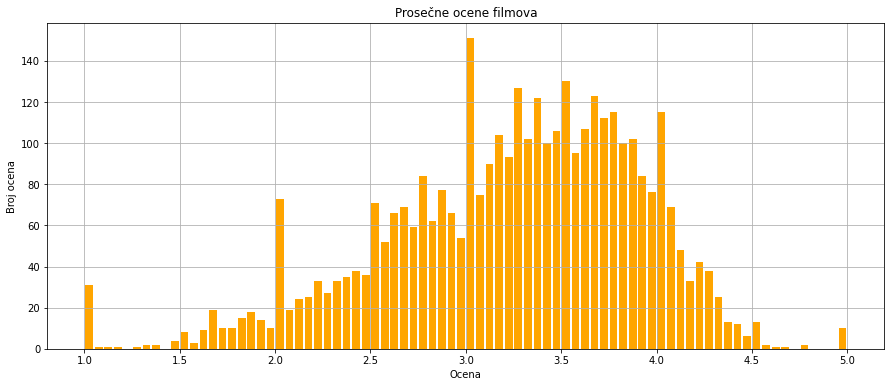

In [14]:
plt.figure(figsize=(15, 6))
ratings['rating'].hist(bins=80, rwidth=0.8, color='orange')
plt.xlabel('Ocena')
plt.ylabel('Broj ocena')
plt.title('Prosečne ocene filmova')
plt.show()

Prikaz broj ocena za svaku prosečnu ocenu filma:

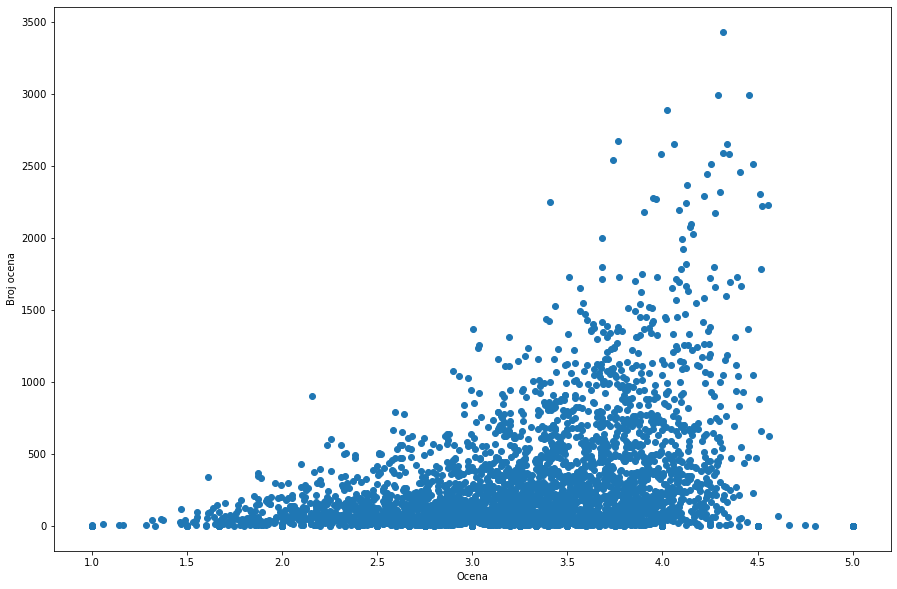

In [15]:
plt.figure(figsize=(15, 10))
plt.scatter(x = ratings['rating'], y = ratings['count'])
plt.xlabel('Ocena')
plt.ylabel('Broj ocena')
plt.show()

Prikaz prosečne ocene za svaki žanr i prikaz broja filmova za svaki žanr za koji je određena prosečna ocena:

In [16]:
genres = []
for x in ratings['genre'].sort_values(ascending=False):
    if ("|" in x):
        for y in x.split("|"):
            if (y not in genres):
                genres.append(y)
    else:
        if (x not in genres):
            genres.append(x)

In [17]:
number_of_genres = {}
average_ratings_for_genres = []
for x in genres:
    number_of_genres[x] = len(ratings[ratings['genre'].apply(lambda y: x in y)])
    average_ratings_for_genres.\
        append(ratings[ratings['genre'].apply(lambda y: True if (('|' in y and x in y) or x == y) else False)].mean().rating)

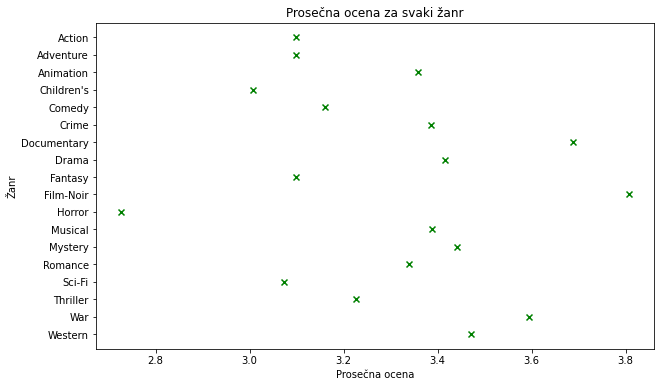

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(x = average_ratings_for_genres, y = genres, color='green', marker='x')
plt.ylabel('Žanr')
plt.xlabel('Prosečna ocena')
plt.title('Prosečna ocena za svaki žanr')
plt.show()

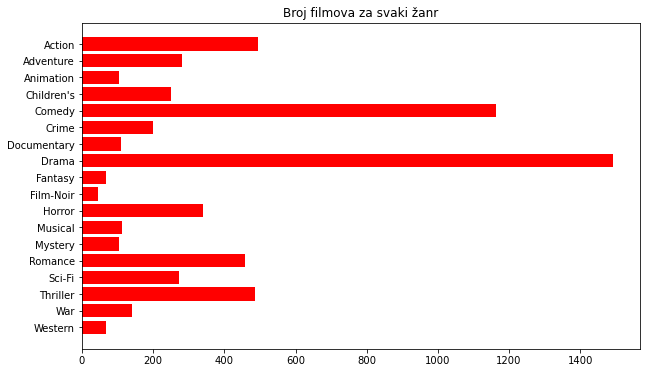

In [19]:
plt.figure(figsize=(10, 6))
plt.barh(genres, list(number_of_genres.values()), color='red')
plt.title('Broj filmova za svaki žanr')
plt.show()

### Rad sa podacima
Podela podataka na trening i test skup:

In [20]:
train_data, test_data = model_selection.train_test_split(data_movies, test_size = 0.2, random_state = 7)

In [21]:
train_data.sort_values(by='user')

,user,item,rating,timestemp,title,genre
8222,1,1287,5,978302039,Ben-Hur (1959),Action|Adventure|Drama
28501,1,48,5,978824351,Pocahontas (1995),Animation|Children's|Musical|Romance
32698,1,1545,4,978824139,Ponette (1996),Drama
5904,1,1197,3,978302268,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance
8926,1,2804,5,978300719,"Christmas Story, A (1983)",Comedy|Drama
...,...,...,...,...,...,...
321526,6040,34,4,956704584,Babe (1995),Children's|Comedy|Drama
100604,6040,1834,4,956705073,"Spanish Prisoner, The (1997)",Drama|Thriller
40374,6040,2762,4,956704584,"Sixth Sense, The (1999)",Thriller
45032,6040,1961,4,956703977,Rain Man (1988),Drama


In [22]:
test_data.sort_values(by = 'user')

,user,item,rating,timestemp,title,genre
15859,1,1035,5,978301753,"Sound of Music, The (1965)",Musical
2250,1,914,3,978301968,My Fair Lady (1964),Musical|Romance
33428,1,2294,4,978824291,Antz (1998),Animation|Children's
23270,1,1270,5,978300055,Back to the Future (1985),Comedy|Sci-Fi
36324,1,1907,4,978824330,Mulan (1998),Animation|Children's
...,...,...,...,...,...,...
464888,6040,904,4,956716845,Rear Window (1954),Mystery|Thriller
647187,6040,2455,3,956715865,"Fly, The (1986)",Horror|Sci-Fi
999123,6040,2503,5,956704191,"Apple, The (Sib) (1998)",Drama
888155,6040,1280,4,957717017,Raise the Red Lantern (1991),Drama


In [23]:
number_of_users = train_data['user'].unique().shape[0]

In [24]:
number_of_users

6040

In [25]:
number_of_items = train_data['item'].unique().shape[0]

In [26]:
number_of_items

3680

In [27]:
max_item = train_data['item'].max()

In [28]:
max_item

3952

In [29]:
train_data['item'].min()

1

In [30]:
train_data['user'].min()

1

In [31]:
train_data['user'].max()

6040

Kreiraćemo user_item matricu koja će biti dimenzije <i><b>number_of_users</b></i> x <i><b>max_item</b></i>:

In [32]:
user_item_matrix = np.zeros((number_of_users, max_item))
for row in train_data.itertuples(): # da li ovde treba train_data??
    user_item_matrix[row[1]-1, row[2]-1] = row[3]

In [33]:
user_item_matrix

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [34]:
zero = np.sum(user_item_matrix == 0)

In [35]:
zero

23069913

In [36]:
user_item_matrix.shape

(6040, 3952)

In [37]:
fields = user_item_matrix.shape[0]*user_item_matrix.shape[1]

In [38]:
fields

23870080

In [39]:
fields - zero

800167

In [40]:
common_items = (user_item_matrix[0,:] != 0) & (user_item_matrix[1,:] !=0)

In [41]:
np.sum(common_items==True)

4

In [42]:
user_item_matrix[0, common_items]

array([5., 4., 3., 5.])

Dodaćemo funkciju koja će služiti za računanje kovarijanse između dva usera:

In [43]:
def calculate_covariance_between_users(ui_matrix, i, j):
    if (i != j):
        ratings_i = ui_matrix[i,:]
        ratings_j = ui_matrix[j,:]
    
        common_items = (ratings_i != 0) & (ratings_j != 0)
    
        part1 = np.sum(ratings_i[common_items]*ratings_j[common_items])*(1/number_of_items)
        part2 = np.sum(ratings_i)*np.sum(ratings_j)*(1/(number_of_items**2)) # da li je number of items ili max items
    
        return part1 - part2
    else:
        return float('inf')
    

In [44]:
calculate_covariance_between_users(user_item_matrix, 1, 2)

0.02744978733459358

In [45]:
calculate_covariance_between_users(user_item_matrix, 2, 1)

0.02744978733459358

In [46]:
calculate_covariance_between_users(user_item_matrix, 344, 2413)

0.010853098416824199

In [47]:
calculate_covariance_between_users(user_item_matrix, 2413, 344)

0.010853098416824199

In [48]:
calculate_covariance_between_users(user_item_matrix, 1, 1)

inf

Pomoću funkcije <i>calculate_covaraiance_between_users</i> izračunaćemo matricu kovarijansi za sve usere:

In [49]:
covariance_matrix = np.zeros((number_of_users, number_of_users))

In [50]:
for i in range(number_of_users):
    for j in range(i, number_of_users):
        covariance_matrix[i, j] = calculate_covariance_between_users(user_item_matrix, i, j)
        covariance_matrix[j, i] = covariance_matrix[i, j]

In [51]:
covariance_matrix

array([[        inf,  0.01530777,  0.0136035 , ..., -0.00062027,
         0.02283199,  0.03440926],
       [ 0.01530777,         inf,  0.02744979, ...,  0.00808202,
         0.01363938,  0.10537541],
       [ 0.0136035 ,  0.02744979,         inf, ...,  0.01166706,
         0.0085716 ,  0.03501418],
       ...,
       [-0.00062027,  0.00808202,  0.01166706, ...,         inf,
         0.00740341,  0.01706345],
       [ 0.02283199,  0.01363938,  0.0085716 , ...,  0.00740341,
                inf,  0.06210716],
       [ 0.03440926,  0.10537541,  0.03501418, ...,  0.01706345,
         0.06210716,         inf]])

In [52]:
covariance_matrix[1,2]

0.02744978733459358

In [53]:
covariance_matrix[2, 1]

0.02744978733459358

In [54]:
covariance_matrix[0,0]

inf

In [55]:
covariance_matrix[6039, 0]

0.03440926275992439

In [56]:
covariance_matrix[0, 6039]

0.03440926275992439

In [57]:
np.sum(covariance_matrix == 0)

76

Funkcija <i>GetKSimilarUser</i> vraća listu K najsličnijih usera za prosleđenog usera:

In [58]:
def GetKSimilarUser(user_i, K):
    user_values = covariance_matrix[user_i,:]
    values = user_values.argsort()[-K-1:]
    
    return values[0:K]

In [59]:
print(GetKSimilarUser(0, 10))
for i in GetKSimilarUser(0,10):
    print(covariance_matrix[0, i])

[2072 5358 1696 1265 3589  423 1050 5099 1111 1119]
0.10770557655954631
0.10887228260869565
0.10902646502835539
0.11045663988657847
0.1122412570888469
0.11259806238185258
0.11319884215500946
0.11327681947069945
0.11866198015122875
0.11984936200378073


Funkcija <i>GetKDSimilarUser</i> vraća listu K najnesličnijih usera za prosleđenog usera:

In [60]:
def GetKDSimilarUser(user_i, K):
    user_values = covariance_matrix[user_i,:]
    
    return user_values.argsort()[:K]

In [61]:
np.flipud(covariance_matrix[0,:].argsort()[-10-1:][0:10]) # funkcija za obrtanje niza

array([1119, 1111, 5099, 1050,  423, 3589, 1265, 1696, 5358, 2072],
      dtype=int64)

In [62]:
a = covariance_matrix[0,:].argsort()[:10]
print(a)
for i in a:
    print(covariance_matrix[0, i])

[1666 3901 4013 1489 2020 4242 5530 3770 3800 4241]
-0.016573724007561436
-0.008472944234404535
-0.008063563327032135
-0.0070959357277882796
-0.00579336011342155
-0.005706521739130434
-0.005582466918714555
-0.005563563327032135
-0.005148275047258979
-0.005111058601134215


In [63]:
ru_average = user_item_matrix[0, :].mean()
ru_average

s = np.zeros(10)
s

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [64]:
def predict_rating(user_u, item_i, Nus, Nud, COV, UI, K, alpha): # ovo nam ne treba vise ceo kod je u algoritmu
    ru_average = UI[user_u-1, UI[user_u-1, :] != 0].mean()
    similar = np.zeros(K)
    divide_s = np.zeros(K)
    disimilar = np.zeros(K)
    divide_ds = np.zeros(K)
    
    for i in range(K):
        similar[i] = COV[user_u-1, Nus[i]]*(UI[Nus[i],item_i-1] - UI[Nus[i], :].mean())
        divide_s[i] = np.abs(COV[user_u-1, Nus[i]])
        disimilar[i] = np.abs(COV[user_u-1, Nud[i]])*(UI[Nud[i],item_i-1] - UI[Nud[i], :].mean())
        divide_ds = np.abs(COV[user_u-1, Nud[i]])
        
    rui = ru_average + alpha * (np.sum(similar)/np.sum(divide_s)) + (1-alpha) * (np.sum(disimilar)/np.sum(divide_ds))
    
    return rui

In [65]:
Nus = GetKSimilarUser(200, 10)
Nud = GetKDSimilarUser(200, 10)

In [66]:
predict_rating(200, 100, Nus, Nud, covariance_matrix, user_item_matrix, 10, 0.8)

2.4338773842254504

In [67]:
user_item_matrix[200, user_item_matrix[200,:] != 0].mean()

3.985294117647059

In [69]:
def CFCM(UI, user_u, alpha, K, N):
    Nus = GetKSimilarUser(user_u, K)
    Nud = GetKDSimilarUser(user_u, K)
    
    # prosecna ocena koju je dao user, izracunata samo nad itemima koji nisu 0
    ru_average = UI[user_u-1, UI[user_u-1, :] != 0].mean()
    # niz predvidjenih ocena za sve iteme
    all_predicted_ratings = np.zeros(max_item)
    # drugo, krace ime za matricu kovarijansi
    COV = covariance_matrix
    
    
    for item_i in range(max_item):
        
        # za racunanje dela iznad razlomacke crte u prvom delu gde se posmatraju slicni
        similar = np.zeros(K)
        # za racunanje dela ispod razlomacke crte u prvom delu gde se posmatraju slicni
        divide_s = np.zeros(K)
        # za racunanje dela iznad razlomacke crte u drugom delu gde se posmatraju razliciti
        disimilar = np.zeros(K)
        # za racunanje dela ispod razlomacke crte u drugom delu gde se posmatraju razliciti
        divide_ds = np.zeros(K)
    
        for i in range(K):
            similar[i] = COV[user_u-1, Nus[i]]*(UI[Nus[i],item_i-1] - UI[Nus[i], :].mean())
            divide_s[i] = np.abs(COV[user_u-1, Nus[i]])
            disimilar[i] = np.abs(COV[user_u-1, Nud[i]])*(UI[Nud[i],item_i-1] - UI[Nud[i], :].mean())
            divide_ds = np.abs(COV[user_u-1, Nud[i]])
        
        # formula iz algoritma
        rui = ru_average + alpha * (np.sum(similar)/np.sum(divide_s)) + (1-alpha) * (np.sum(disimilar)/np.sum(divide_ds))
        # za svaki element stavljamo u niz
        all_predicted_ratings[item_i] = rui
        
    # uzimamo prvih N najboljih predloga za usera u     
    Result = np.flipud(all_predicted_ratings.argsort())[:N]
    return Result

In [71]:
CFCM(user_item_matrix, 200, 0.8, 10, 5)

array([ 858,  589, 1214, 1097, 3471], dtype=int64)

In [72]:
# U narednom delu sledi proba da li matrica kovarijansi dobro radi
# proba se sastoji u tome da se primeni na podatke iz naucnog rada i da se utvrdi da li se dobija ista matrica
# Dobija se ista matrica jeeeeeeej

In [73]:
# Aaaaaaliiiii postoji caka, ovde je koriscen broj itema koji je ocigledno 6, a u nasem radu je koriscen broj itema 
# number of items koji je 3673 dok je max item 3952.... to se mora razmisliti 

In [74]:
ui_proba = np.array([0, 5, 2, 0, 3, 0, 4, 0, 0, 3, 0, 4, 0, 0, 2, 0, 0, 2, 5, 0, 0, 3, 0, 0, 0, 5, 5, 0, 0, 3])

In [75]:
ui_proba

array([0, 5, 2, 0, 3, 0, 4, 0, 0, 3, 0, 4, 0, 0, 2, 0, 0, 2, 5, 0, 0, 3,
       0, 0, 0, 5, 5, 0, 0, 3])

In [76]:
ui_proba = ui_proba.reshape(5, 6)

In [77]:
def calculate_covariance_proba(ui_matrix, i, j):
    if (i != j):
        ratings_i = ui_matrix[i,:]
        ratings_j = ui_matrix[j,:]
    
        common_items = (ratings_i != 0) & (ratings_j != 0)
    
        part1 = np.sum(ratings_i[common_items]*ratings_j[common_items])*(1/6)
        part2 = np.sum(ratings_i)*np.sum(ratings_j)*(1/(6**2))
    
        return part1 - part2
    else:
        return float('inf')
    

In [78]:
cov_proba = np.zeros((5, 5))
for i in range(5):
    for j in range(i, 5):
        cov_proba[i, j] = calculate_covariance_proba(ui_proba, i, j)
        cov_proba[j, i] = cov_proba[i, j]

In [79]:
cov_proba

array([[        inf, -3.05555556, -0.44444444, -2.22222222,  2.22222222],
       [-3.05555556,         inf,  0.11111111,  2.38888889, -1.97222222],
       [-0.44444444,  0.11111111,         inf, -0.88888889,  1.22222222],
       [-2.22222222,  2.38888889, -0.88888889,         inf, -2.88888889],
       [ 2.22222222, -1.97222222,  1.22222222, -2.88888889,         inf]])